In [1]:
#Import Libraries
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet import ResNet152
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.callbacks import EarlyStopping
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras import layers
import tensorflow as tf
import numpy as np

In [2]:
#load the directories
training_dir = '../input/dataset/MultiDataset/Training'
val_dir = '../input/dataset/MultiDataset/Validation'

In [3]:
#Variables declaration
IMG_SIZE = (224,224)
EPOCHS   = 100
BATCH_SIZE  = 128
RANDOM_SEED = 1403
augmentation     = True
rotation_range   = 0.1
zoom_range       = 0.1
shear_range      = 0.1
fill_mode        = 'nearest'

In [4]:
if augmentation:
    train_datagen   = ImageDataGenerator(preprocessing_function = preprocess_input,
                                         rotation_range     = rotation_range,
                                         zoom_range         = zoom_range,
                                         shear_range        = shear_range,
                                         fill_mode          = fill_mode)
else:
    train_datagen   = ImageDataGenerator(preprocessing_function = preprocess_input)

val_datagen         = ImageDataGenerator(preprocessing_function = preprocess_input)

In [5]:
train_data = train_datagen.flow_from_directory(
    training_dir,
    target_size = IMG_SIZE,
    color_mode  = 'rgb',
    class_mode  = 'categorical',
    shuffle     = 'True',
    batch_size  = BATCH_SIZE,
    seed        = RANDOM_SEED
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size = IMG_SIZE,
    color_mode  = 'rgb',
    class_mode  = 'categorical',
    shuffle     = 'True',
    batch_size  = BATCH_SIZE,
    seed        = RANDOM_SEED
)

Found 13649 images belonging to 4 classes.
Found 4199 images belonging to 4 classes.


# Model

In [6]:
def create_compile_fit_model(model_name):
    if(model_name == 'ResNet152'):
        base_model = ResNet152(weights ='imagenet', include_top = False, input_shape = IMG_SIZE + (3,))
    if(model_name == 'VGG16'):
        base_model = VGG16(weights ='imagenet', include_top = False, input_shape = IMG_SIZE + (3,))
    if(model_name == 'VGG19'):
        base_model = VGG19(weights ='imagenet', include_top = False, input_shape = IMG_SIZE + (3,))

    model = Sequential()
    model.add(base_model)
    model.add(layers.Dropout(0.2))
    model.add(layers.Flatten())
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(4, activation = 'softmax'))
    model.layers[0].trainable = False

    #Compile the model
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

    #Stopping criteria
    es     = EarlyStopping(monitor = 'val_loss', mode = 'min',patience = 10)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor = np.sqrt(0.1), patience = 5,cooldown = 0, min_lr = 0.5e-6)
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint('./multiclass_' + model_name + '.h5', monitor = 'val_accuracy', save_best_only = True, mode = 'max')

    #Fit the model
    hist = model.fit(train_data, batch_size = BATCH_SIZE, epochs = EPOCHS, shuffle = True,
                     validation_data = val_data,callbacks = [es, model_checkpoint, reduce_lr], verbose = 1)

    return model, hist

# Plot

In [7]:
#Plot training-validation accuracy and loss
def plot_accuracy_loss(hist):
    
    train_acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    print("Maximum Accuracy of Train Set {}".format(max(train_acc)))
    print("Maximum Accuracy of Validation Set {}".format(max(val_acc)))

    train_loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    print("\nMinimum Loss of Train Set {}".format(min(train_loss)))
    print("Minimum Loss of Validation Set {}".format(min(val_loss)))

    #plot the accuracy and loss of training-validation sets
    plt.plot(train_acc)
    plt.plot(val_acc)
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.ylabel("Accuracy-Loss")
    plt.xlabel("Epoch")
    plt.legend(["Training Accuracy","Validation Accuracy","Training loss","Validation Loss"])
    plt.show()
    
    
#Plot learning rate
def plot_learning_rate(hist):
    f, ax = plt.subplots()
    ax.plot([None] + hist.history['lr'], 'o-')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Learning Rate')

# VGG-16 model

In [8]:
#VGG-16 Model
vgg16_model, vgg16_history = create_compile_fit_model('VGG16')

2022-03-17 19:52:46.222104: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-17 19:52:46.297699: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-17 19:52:46.298400: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-17 19:52:46.299403: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 0s 0us/step


2022-03-17 19:52:51.104876: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-03-17 19:52:54.780202: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


107/107 [==============================] - 281s 2s/step - loss: 0.6030 - accuracy: 0.7696 - val_loss: 0.2871 - val_accuracy: 0.8926
Epoch 2/100
107/107 [==============================] - 175s 2s/step - loss: 0.2894 - accuracy: 0.8930 - val_loss: 0.2226 - val_accuracy: 0.9157
Epoch 3/100
107/107 [==============================] - 174s 2s/step - loss: 0.2179 - accuracy: 0.9201 - val_loss: 0.1963 - val_accuracy: 0.9305
Epoch 4/100
107/107 [==============================] - 174s 2s/step - loss: 0.2030 - accuracy: 0.9270 - val_loss: 0.1974 - val_accuracy: 0.9312
Epoch 5/100
107/107 [==============================] - 174s 2s/step - loss: 0.1841 - accuracy: 0.9340 - val_loss: 0.1808 - val_accuracy: 0.9388
Epoch 6/100
107/107 [==============================] - 175s 2s/step - loss: 0.1716 - accuracy: 0.9370 - val_loss: 0.1679 - val_accuracy: 0.9452
Epoch 7/100
107/107 [==============================] - 175s 2s/step - loss: 0.1576 - accuracy: 0.9429 - val_loss: 0.1621 - val_accuracy: 0.9471
Epoc

In [9]:
#Summary of VGG-16 model
vgg16_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 25088)             100352    
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 4)                 100356    
Total params: 14,915,396
Trainable params: 150,532
Non-trainable params: 14,764,864
______________________________________

Maximum Accuracy of Train Set 0.9692285060882568
Maximum Accuracy of Validation Set 0.9647535085678101

Minimum Loss of Train Set 0.08642399311065674
Minimum Loss of Validation Set 0.14279702305793762


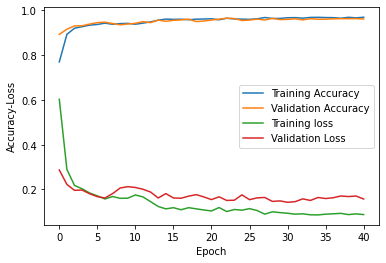

In [10]:
#plot accuracy-loss of training-validation set
plot_accuracy_loss(vgg16_history)

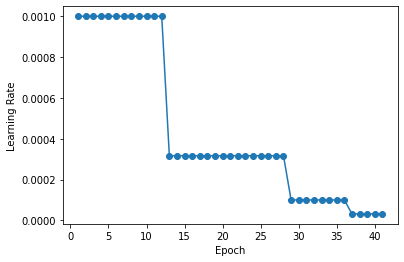

In [11]:
#plot learning rate to see how drop it
plot_learning_rate(vgg16_history)

In [12]:
#save the best fit of VGG-16 model
vgg16_model.save('./multiclass_VGG16.h5')

In [13]:
#Evaluate on Training data
train_score = vgg16_model.evaluate(train_data)
print('For VGG-16 model, Training loss {:.4f}, accuracy {:.2f}% '.format(train_score[0], train_score[1] * 100))

107/107 [==============================] - 163s 2s/step - loss: 0.0484 - accuracy: 0.9942
For VGG-16 model, Training loss 0.0484, accuracy 99.42% 


In [14]:
#Evaluate on validation data
val_score = vgg16_model.evaluate(val_data)
print('For VGG-16 model, Validation loss {:.4f}, accuracy {:.2f}%'.format(val_score[0], val_score[1] * 100))

33/33 [==============================] - 14s 432ms/step - loss: 0.1574 - accuracy: 0.9614
For VGG-16 model, Validation loss 0.1574, accuracy 96.14%


# VGG-19 Model

In [15]:
#VGG-19 Model
vgg19_model, vgg19_history = create_compile_fit_model('VGG19')

80150528/80134624 [==============================] - 0s 0us/step
Epoch 1/100
107/107 [==============================] - 181s 2s/step - loss: 0.5996 - accuracy: 0.7750 - val_loss: 0.2792 - val_accuracy: 0.9024
Epoch 2/100
107/107 [==============================] - 180s 2s/step - loss: 0.2797 - accuracy: 0.8958 - val_loss: 0.2061 - val_accuracy: 0.9326
Epoch 3/100
107/107 [==============================] - 180s 2s/step - loss: 0.2164 - accuracy: 0.9212 - val_loss: 0.1879 - val_accuracy: 0.9417
Epoch 4/100
107/107 [==============================] - 182s 2s/step - loss: 0.2019 - accuracy: 0.9283 - val_loss: 0.1642 - val_accuracy: 0.9495
Epoch 5/100
107/107 [==============================] - 181s 2s/step - loss: 0.1854 - accuracy: 0.9319 - val_loss: 0.1615 - val_accuracy: 0.9502
Epoch 6/100
107/107 [==============================] - 181s 2s/step - loss: 0.1743 - accuracy: 0.9366 - val_loss: 0.1966 - val_accuracy: 0.9362
Epoch 7/100
107/107 [==============================] - 181s 2s/step - l

In [16]:
#Summary of VGG-19 model
vgg19_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 512)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 25088)             100352    
_________________________________________________________________
dropout_3 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 100356    
Total params: 20,225,092
Trainable params: 150,532
Non-trainable params: 20,074,560
____________________________________

Maximum Accuracy of Train Set 0.9643930196762085
Maximum Accuracy of Validation Set 0.9688020944595337

Minimum Loss of Train Set 0.0983477458357811
Minimum Loss of Validation Set 0.13321612775325775


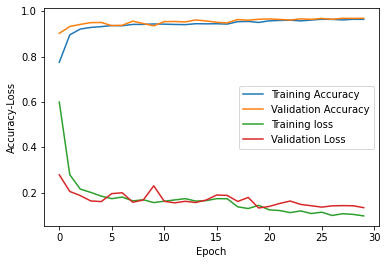

In [17]:
#plot accuracy-loss of training-validation set
plot_accuracy_loss(vgg19_history)

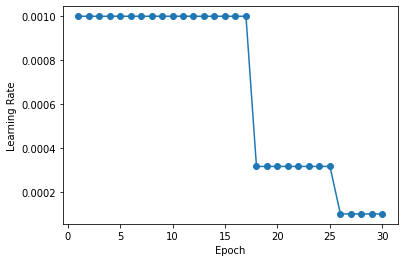

In [18]:
#plot learning rate to see how drop it
plot_learning_rate(vgg19_history)

In [19]:
#save the best fit of VGG-19 model
vgg19_model.save('./multiclass_VGG19.h5')

In [20]:
#Evaluate on Training data
train_score = vgg19_model.evaluate(train_data)
print('For VGG-19 model, Training loss {:.4f}, accuracy {:.2f}% '.format(train_score[0], train_score[1] * 100))

107/107 [==============================] - 166s 2s/step - loss: 0.0487 - accuracy: 0.9927
For VGG-19 model, Training loss 0.0487, accuracy 99.27% 


In [21]:
#Evaluate on validation data
val_score = vgg19_model.evaluate(val_data)
print('For VGG-19 model, Validation loss {:.4f}, accuracy {:.2f}%'.format(val_score[0], val_score[1] * 100))

33/33 [==============================] - 15s 434ms/step - loss: 0.1348 - accuracy: 0.9688
For VGG-19 model, Validation loss 0.1348, accuracy 96.88%


# ResNet-152

In [22]:
#ResNet-152 Model
resnet152_model, resnet152_history = create_compile_fit_model('ResNet152')

234708992/234698864 [==============================] - 1s 0us/step
Epoch 1/100
107/107 [==============================] - 206s 2s/step - loss: 0.6710 - accuracy: 0.8246 - val_loss: 0.3335 - val_accuracy: 0.8964


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
107/107 [==============================] - 197s 2s/step - loss: 0.2441 - accuracy: 0.9276 - val_loss: 0.3433 - val_accuracy: 0.9047
Epoch 3/100
107/107 [==============================] - 195s 2s/step - loss: 0.2119 - accuracy: 0.9425 - val_loss: 0.3473 - val_accuracy: 0.9257
Epoch 4/100
107/107 [==============================] - 196s 2s/step - loss: 0.1832 - accuracy: 0.9525 - val_loss: 0.2201 - val_accuracy: 0.9467
Epoch 5/100
107/107 [==============================] - 196s 2s/step - loss: 0.1793 - accuracy: 0.9560 - val_loss: 0.3391 - val_accuracy: 0.9283
Epoch 6/100
107/107 [==============================] - 196s 2s/step - loss: 0.1631 - accuracy: 0.9615 - val_loss: 0.2853 - val_accuracy: 0.9426
Epoch 7/100
107/107 [==============================] - 197s 2s/step - loss: 0.1407 - accuracy: 0.9683 - val_loss: 0.2200 - val_accuracy: 0.9543
Epoch 8/100
107/107 [==============================] - 198s 2s/step - loss: 0.1291 - accuracy: 0.9705 - val_loss: 0.2134 - val_accuracy:

In [23]:
#Summary of VGG-16 model
resnet152_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152 (Functional)       (None, 7, 7, 2048)        58370944  
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 7, 2048)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 100352)            0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 100352)            401408    
_________________________________________________________________
dropout_5 (Dropout)          (None, 100352)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 401412    
Total params: 59,173,764
Trainable params: 602,116
Non-trainable params: 58,571,648
____________________________________

Maximum Accuracy of Train Set 0.9948714375495911
Maximum Accuracy of Validation Set 0.9864253401756287

Minimum Loss of Train Set 0.02328346110880375
Minimum Loss of Validation Set 0.08101002871990204


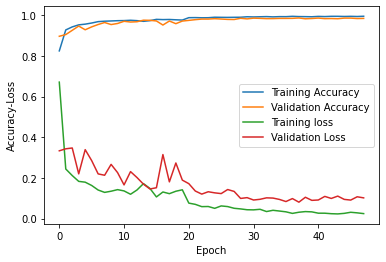

In [24]:
#plot accuracy-loss of training-validation set
plot_accuracy_loss(resnet152_history)

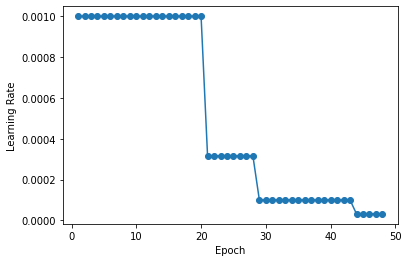

In [25]:
#plot learning rate to see how drop it
plot_learning_rate(resnet152_history)

In [26]:
#save the best fit of ResNet-152 model
resnet152_model.save('./multiclass_ResNet152.h5')

In [27]:
#Evaluate on Training data
train_score = resnet152_model.evaluate(train_data)
print('For ResNet-152  model, Training loss {:.4f}, accuracy {:.2f}% '.format(train_score[0], train_score[1] * 100))

107/107 [==============================] - 177s 2s/step - loss: 0.0061 - accuracy: 0.9991
For ResNet-152  model, Training loss 0.0061, accuracy 99.91% 


In [28]:
##Evaluate on validation data
val_score = resnet152_model.evaluate(val_data)
print('For ResNet-152 model, Validation loss {:.4f}, accuracy {:.2f}%'.format(val_score[0], val_score[1] * 100))

33/33 [==============================] - 17s 505ms/step - loss: 0.1021 - accuracy: 0.9843
For ResNet-152 model, Validation loss 0.1021, accuracy 98.43%
